# GradientBoostingClassifier w/ GridSearchCV (Cancer Dataset) #

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings 
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [50]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Read in data, treating "?" as NaN and trimming whitespace
df = pd.read_csv(
    url
    , header=None
    , names=columns
    , na_values="?"
    , skipinitialspace=True
)

# Quick look at the data
df.head()
df.info()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [51]:
# Now you can inspect missing values
df.isnull().sum().sort_values(ascending=False)

occupation        1843
workclass         1836
native-country     583
age                  0
fnlwgt               0
education            0
education-num        0
marital-status       0
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
income               0
dtype: int64

In [52]:
# Drop rows with missing values for simplicity
df_clean = df.dropna()
df_clean.shape
df_clean.info()

(30162, 15)

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  native-country  30162 non-null  object
 14  income          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [53]:
# Identify categorical columns
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]

# One-hot encode categoricals, drop_first avoids collinearity
df_encoded = pd.get_dummies(
    df_clean
    , columns=categorical_cols
    , drop_first=True
)

# Convert target variable to binary
df_encoded['income'] = df_encoded['income'].map(
    {'<=50K': 0, '>50K': 1}
)

df_encoded.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [54]:
# Separate features and target
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

In [55]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
    , random_state=27
    , stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24129, 96), (6033, 96), (24129,), (6033,))

In [57]:
# Initialize Gradient Boosting Classifier with common parameters

gbc = GradientBoostingClassifier(
    n_estimators=100      # Number of boosting stages (trees)
    , learning_rate=0.1   # Shrinkage rate applied to each tree
    , max_depth=3         # Maximum depth of each tree (controls complexity)
    , subsample=1.0       # Fraction of samples for fitting each base learner
    , random_state=27     # Ensures reproducibility
)

In [58]:
# Fit (train) the model
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=27)

In [59]:
# Make predictions on the test set
y_pred_base = gbc.predict(X_test)

In [60]:
# Evaluate using accuracy and classification report
accurracy_base = accuracy_score(y_test, y_pred_base)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4531
           1       0.77      0.66      0.71      1502

    accuracy                           0.87      6033
   macro avg       0.83      0.80      0.81      6033
weighted avg       0.86      0.87      0.86      6033



In [61]:
accurracy_base

0.8640808884468755

In [62]:
gbc.score(X_test, y_test)

0.8640808884468755

In [63]:
from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)

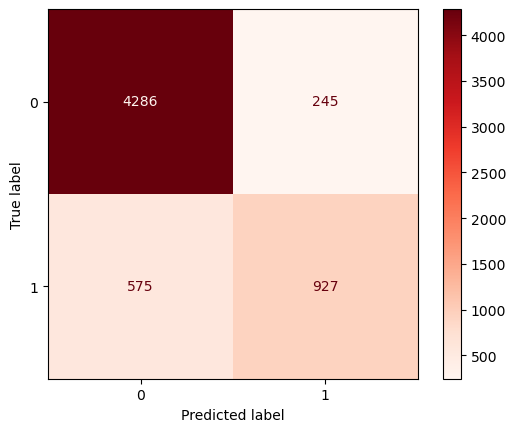

In [65]:
ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, cmap='Reds');

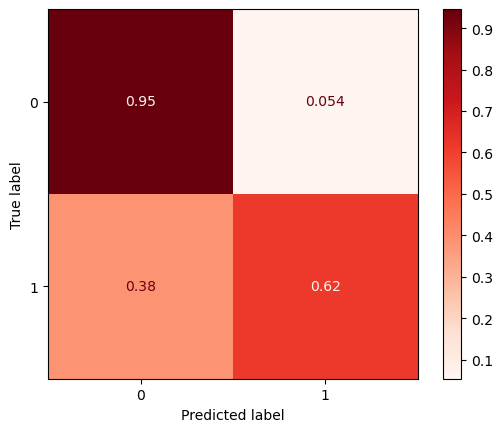

In [66]:
ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, normalize='true', cmap='Reds');

## Running GradientBoostingClassifier in a Grid CV

In [68]:
# Initialize the classifier
gbc_base = GradientBoostingClassifier(
    random_state=27
) 

In [73]:
param_grid = {
    'n_estimators': [50, 100]           # Number of trees
    , 'learning_rate': [0.05, 0.1]      # Step size shrinkage
    , 'max_depth': [3, 5, 7, 9]         # Tree depth (use odd #'s~ tiebreaker problem;)
    , 'subsample': [0.8, 1.0]           # Fraction of samples per tree
    , 'min_samples_split': [2, 5]       # Minimum samples to split
    , 'min_samples_leaf': [1, 3]        # Minimum samples at leaves
}

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=gbc_base
    , param_grid=param_grid
    , cv=3
    , scoring='accuracy'
#     , n_jobs=4          # Use all available CPU cores
    , verbose=1           # Progress messages
)

In [74]:
# Running a 'time' on this as it may take looooooooong - so just curious how long...
%time 

# Fit grid search on training data
grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 14.1 µs
Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=27),
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5], 'n_estimators': [50, 100],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [75]:
# Retrieve the best estimator and parameters
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 0.8}

In [76]:
# Initialize and fit the 'best model' then see how the best boosted model does on test data:
best_gbc = grid_search.best_estimator_
best_gbc.fit(X_train, y_train)

best_gbc.score(X_test, y_test)

GradientBoostingClassifier(max_depth=7, min_samples_leaf=3, random_state=27,
                           subsample=0.8)

0.8678932537709265

In [78]:
# Test the base for shytes n giggles:

gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

GradientBoostingClassifier(random_state=27)

0.8640808884468755

In [79]:
print(f"Grid CV vs Base Score: {np.round((((best_gbc.score(X_test, y_test) - gbc.score(X_test, y_test))/ gbc.score(X_test, y_test))*100), 4)}%")

Grid CV vs Base Score: 0.4412%


In [80]:
# See how the best boosted model does on test data:

# Predict on test set
y_pred = best_gbc.predict(X_test)
score_best = accuracy_score(y_test, y_pred)
score_best

0.8678932537709265

In [81]:
# Eval performance of base to see how much better the 'best_model' is;
y_pred_base = gbc.predict(X_test)
score_base = accuracy_score(y_test, y_pred_base)
score_base

0.8640808884468755

In [82]:
print(f"Best Model vs. Base Model (Accuracy Score) : {np.round((((score_best - score_base) / score_base) * 100), 4)}%")

Best Model vs. Base Model (Accuracy Score) : 0.4412%


In [83]:
from sklearn.metrics import (
    confusion_matrix
    , classification_report 
    , ConfusionMatrixDisplay 
    , roc_auc_score 
    , RocCurveDisplay 
    , PrecisionRecallDisplay )

In [84]:
# Comparison of CMs (tex/array, non-viz) for Best vs. Base:

print("Confusion Matrix, Best Model:")
confusion_matrix(y_test, y_pred)
print('\n')
print("Confusion Matrix, Base Model:")
confusion_matrix(y_test, y_pred_base)

Confusion Matrix, Best Model:


array([[4239,  292],
       [ 505,  997]])



Confusion Matrix, Base Model:


array([[4286,  245],
       [ 575,  927]])

In [85]:
# Comparison of classification reports for Best vs. Base:

print("Classification Report, Best Model:")
print(classification_report(y_test, y_pred))
print('\n')
print("Classification Report, Base Model:")
print(classification_report(y_test, y_pred_base))

Classification Report, Best Model:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4531
           1       0.77      0.66      0.71      1502

    accuracy                           0.87      6033
   macro avg       0.83      0.80      0.81      6033
weighted avg       0.86      0.87      0.86      6033



Classification Report, Base Model:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4531
           1       0.79      0.62      0.69      1502

    accuracy                           0.86      6033
   macro avg       0.84      0.78      0.80      6033
weighted avg       0.86      0.86      0.86      6033



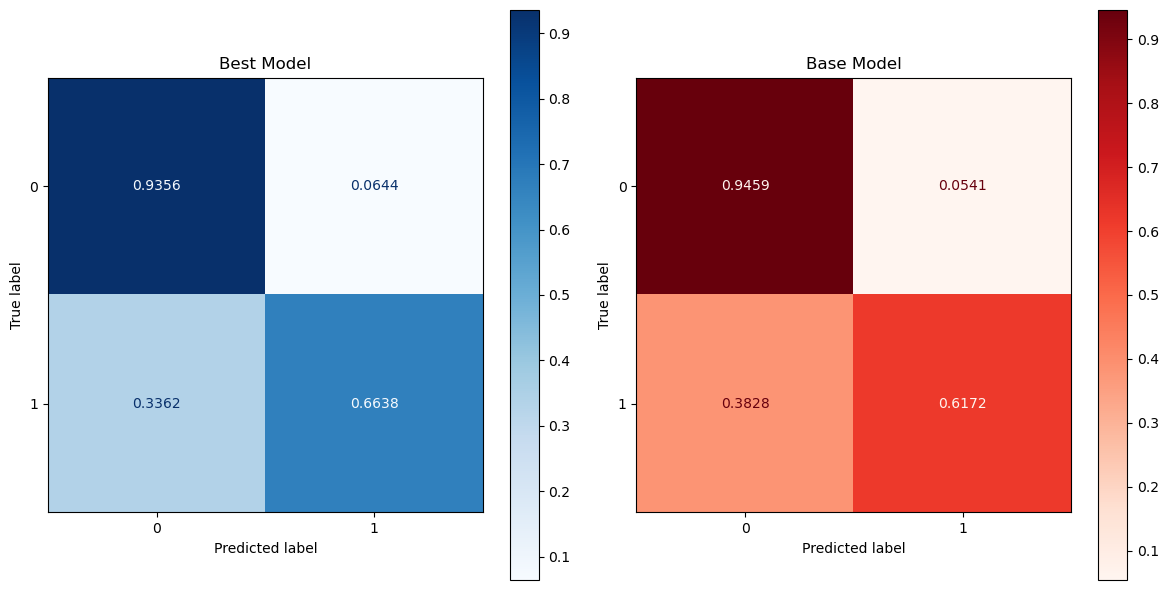

In [87]:
# To do a side-by-side, normalized CM comparison (Best vs. Base):

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_estimator(
    best_gbc, X_test, y_test, normalize='true', cmap='Blues', values_format='.4f'
    , ax=ax[0]
)

ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, normalize='true', cmap='Reds', values_format='.4f'
    , ax=ax[1]
)

ax[0].set_title('Best Model')
ax[1].set_title('Base Model')

plt.tight_layout()
plt.show();

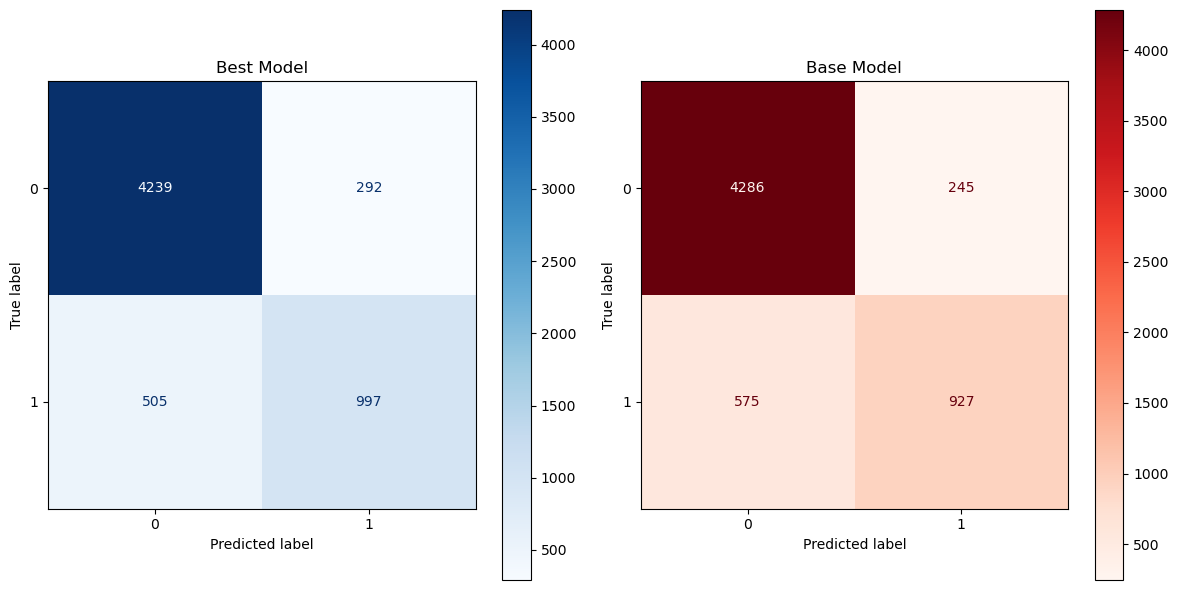

In [86]:
# To do a side-by-side, numerical CM comparison (Best vs. Base):

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_estimator(
    best_gbc, X_test, y_test, cmap='Blues', ax=ax[0]
)

ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, cmap='Reds', ax=ax[1]
)

ax[0].set_title('Best Model')
ax[1].set_title('Base Model')

plt.tight_layout()
plt.show();

In [44]:
# Predict on the test set using the best model
y_pred = best_gbc.predict(X_test)

# Evaluate performance
accuracy_best = accuracy_score(y_test, y_pred)
accuracy_best
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

0.8678932537709265

array([[4239,  292],
       [ 505,  997]])

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4531
           1       0.77      0.66      0.71      1502

    accuracy                           0.87      6033
   macro avg       0.83      0.80      0.81      6033
weighted avg       0.86      0.87      0.86      6033



In [46]:
print(f"Best Model vs. Base Model : {((accuracy_best - accurracy_base) / accurracy_base) * 100}%")

Best Model vs. Base Model : 0.44120468060617635%


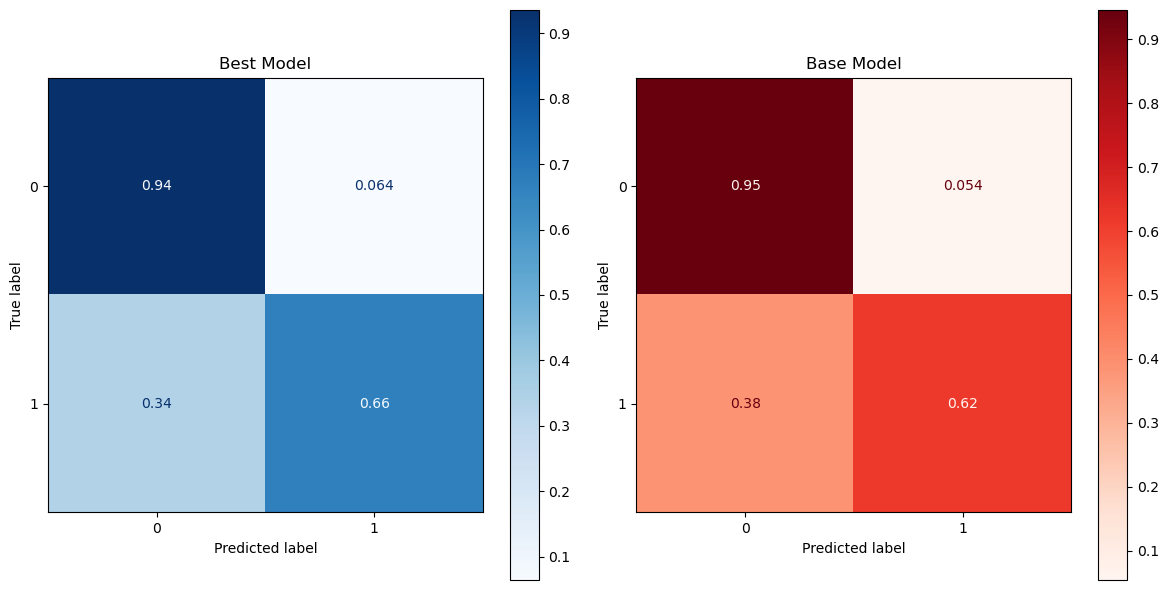

In [37]:
# To do a side-by-side, normalized CM comparison (Best vs. Base):

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_estimator(
    best_gbc, X_test, y_test, normalize='true', cmap='Blues', ax=ax[0])

ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, normalize='true', cmap='Reds', ax=ax[1])

ax[0].set_title('Best Model')
ax[1].set_title('Base Model')

plt.tight_layout()
plt.show();

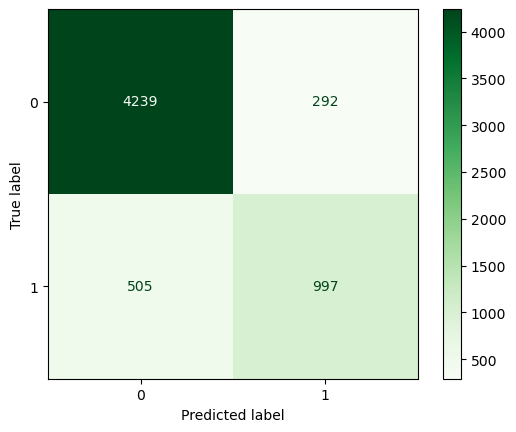

In [27]:
ConfusionMatrixDisplay.from_estimator(
    best_gbc, X_test, y_test, cmap='Greens');

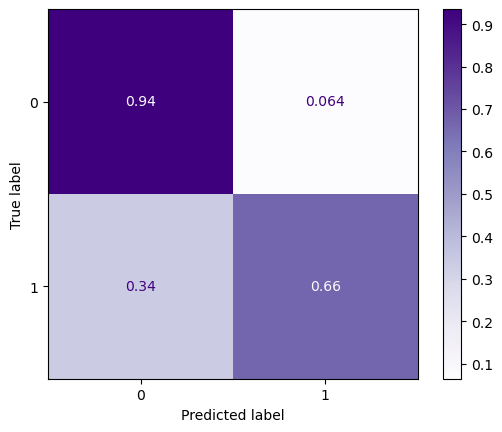

In [29]:
ConfusionMatrixDisplay.from_estimator(
    best_gbc, X_test, y_test, normalize='true', cmap='Purples');

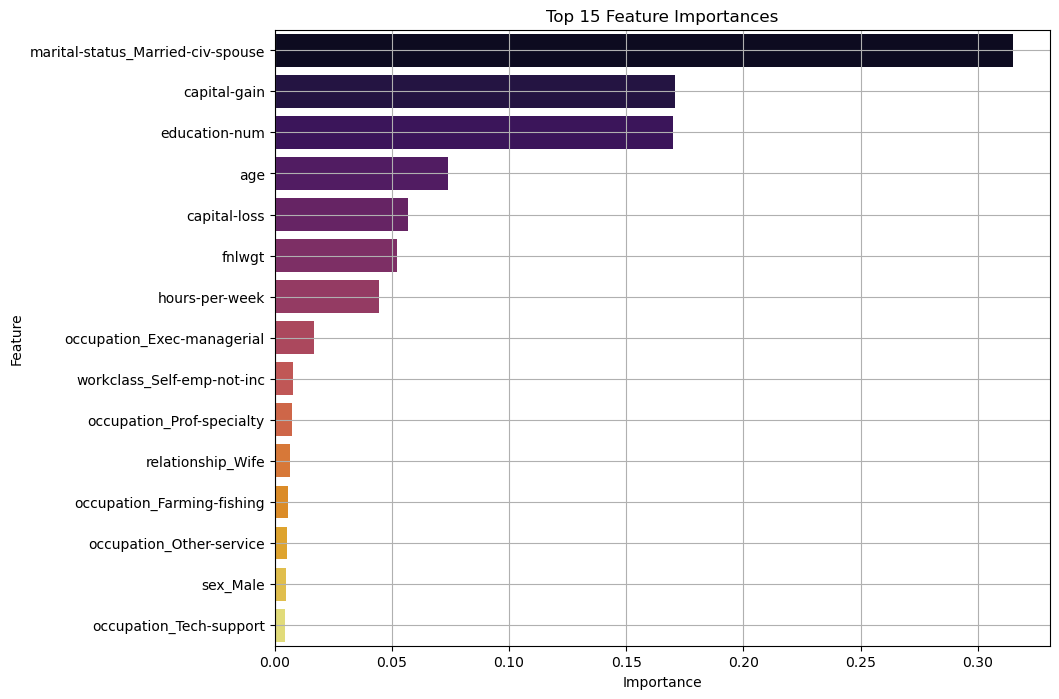

In [33]:
# Updated, more efficient and universally applicable "Feature Importances" plot, which uses a dataframe, rather than piecemeal bits and indices;

feature_importances = pd.DataFrame({
    "Feature": X.columns
    , "Importance": best_gbc.feature_importances_
}).sort_values(
    by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x="Importance", y="Feature"
    , data=feature_importances.head(15)
    , palette="inferno"
)

plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show();

In [35]:
# Temporarily suppress duplicate outputs (have to do this w/ px otherwise, it will output dupe charts!)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

In [36]:
# And now - with plotly express!

import plotly.express as px

# Create a dataframe for feature importances
feature_importances = pd.DataFrame({
    "Feature": X.columns
    , "Importance": best_gbc.feature_importances_
}).sort_values(
    by="Importance"
    , ascending=False)

# Select the top 15 features
top_features = feature_importances.head(15)

# Create the bar chart
fig = px.bar(
    top_features
    , x="Importance"
    , y="Feature"
    , orientation="h"  # Horizontal bar chart
    , title="Top 15 Feature Importances"
    , color="Importance"  # Add color based on importance
    , color_continuous_scale="viridis_r"  # Match the seaborn palette
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title="Importance"
    , yaxis_title="Feature"
    , yaxis=dict(
        autorange="reversed")  # Reverse the y-axis for a similar order to Seaborn
    , template="seaborn"  # Clean background style
)

# Show the figure
fig.show()

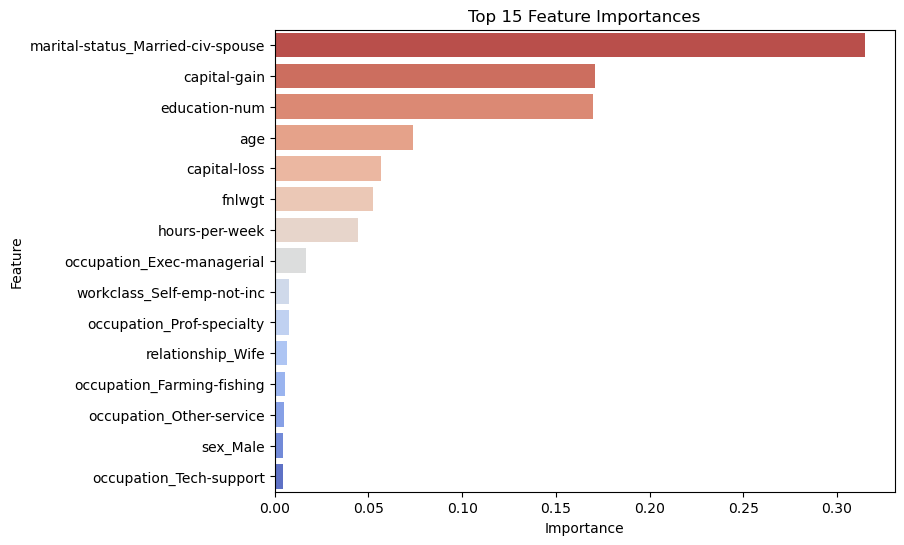

In [30]:
# Feature Importance
importances = grid_search.best_estimator_.feature_importances_
feat_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances[indices][:top_n]
    , y=np.array(feat_names)[indices][:top_n]
    , palette='coolwarm_r'
)
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show();